<a href="https://www.kaggle.com/code/spiritedcoder/cats-and-dogs-classification-using-pytorch?scriptVersionId=150240195" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4329.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4223.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4253.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4190.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4354.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4136.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4226.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4214.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4888.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4170.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4323.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4262.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4788.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4657.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4387.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4255.jpg
/kaggle/

### Importing Necessary Libraries

In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import random
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Checking if gpu is available or not

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data Preprocessing

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 4

train_dataset = datasets.ImageFolder('/kaggle/input/cat-and-dog/training_set/training_set', transform = transform)
test_dataset = datasets.ImageFolder('/kaggle/input/cat-and-dog/test_set/test_set', transform = transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Visualizing Images

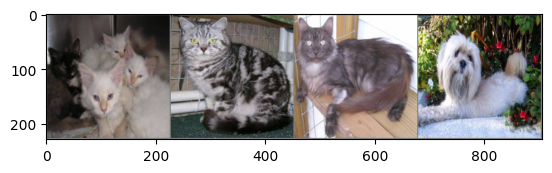

Cat   Cat   Cat   Dog  


In [5]:
classes = ['Cat', 'Dog']

def imshow(image):
    image = image / 2 + 0.5
    npimg = image.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
images, labels = next(iter(train_loader))

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Using ResNet18 To Train

In [6]:
model = models.resnet18(pretrained=True)  # You can use a pre-trained model or create your own
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes: cat and dog

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 147MB/s]


In [7]:
model = model.to(device)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
train_losses = []

for epoch in range(10):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_losses.append(running_loss/ len(train_loader))
    
    print(f'Epoch: {epoch + 1} - Loss: {running_loss/ len(train_loader)}')

Epoch: 1 - Loss: 0.6202091452494435
Epoch: 2 - Loss: 0.4554558807889095
Epoch: 3 - Loss: 0.34191967348812835
Epoch: 4 - Loss: 0.2549701286196061
Epoch: 5 - Loss: 0.20062452080423715
Epoch: 6 - Loss: 0.17226537295099226
Epoch: 7 - Loss: 0.14409189239266382
Epoch: 8 - Loss: 0.1255257822883816
Epoch: 9 - Loss: 0.10001545577422886
Epoch: 10 - Loss: 0.09268551575368239


### Plotting Training Loss

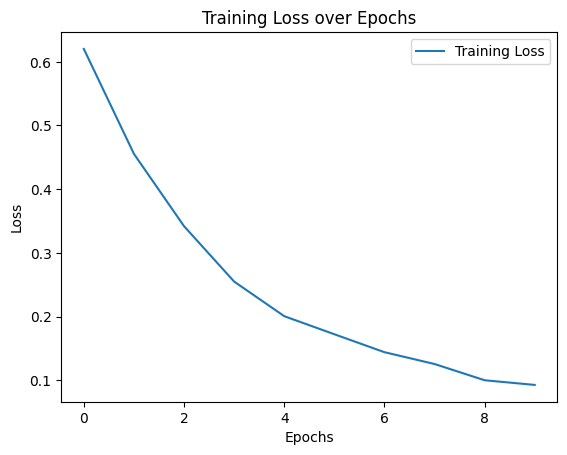

In [10]:
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Evaluating The Model

In [11]:
model.eval()
correct = 0
total = 0
predicted_labels = []
true_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"Accuracy: {accuracy}%")

Accuracy: 93.57390014829461%


### Saving The Model

In [12]:
model_path = 'cats_dogs_classification.pth'

torch.save(model.state_dict(), model_path)

### Visualizing a few images and their labels

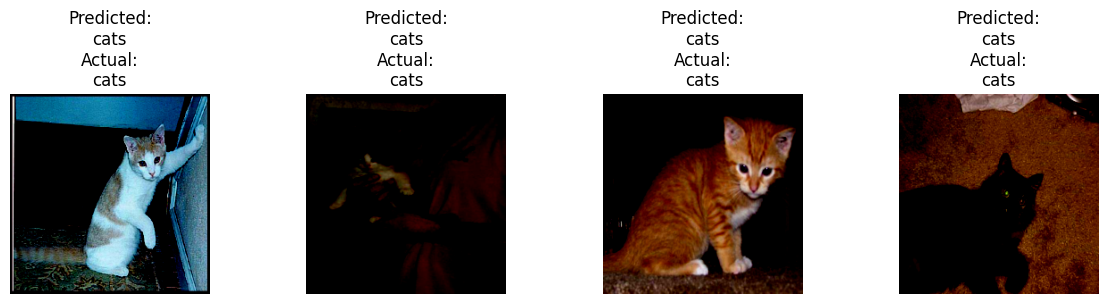

In [13]:
class_labels = {0: 'cats', 1: 'dogs'}

model.eval()

images, labels = next(iter(test_loader))

images = images.to(device)
labels = labels.to(device)

outputs = model(images)
_, predicted = torch.max(outputs, 1)

num_images = len(images)
num_rows = num_images // 4  # Calculate the number of rows for subplots

fig, axes = plt.subplots(num_rows, 4, figsize=(12, 3 * num_rows))

for i, ax in enumerate(axes.flat):
    if i < num_images:  # Ensure the image index is within the available range
        image = np.transpose(images[i].cpu().numpy(), (1, 2, 0))
        ax.imshow(image)
        predicted_label = class_labels[predicted[i].item()]
        actual_label = class_labels[labels[i].item()]

        ax.set_title(f'Predicted:\n{predicted_label}\nActual:\n{actual_label}')
        ax.axis('off')

plt.tight_layout()
plt.show()

### Plotting Confusion Matrix on Heatmap

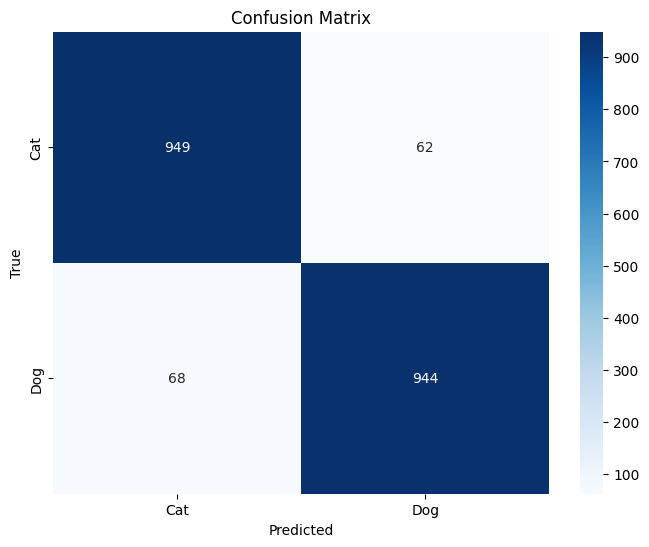

In [14]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()